# K近邻算法实现红酒聚类

本实验主要介绍使用MindSpore在部分wine数据集上进行KNN实验。

## 1、实验目的

- 了解KNN的基本概念；
- 了解如何使用MindSpore进行KNN实验。

## 2、K近邻算法原理介绍

K近邻算法（K-Nearest-Neighbor, KNN）是一种用于分类和回归的非参数统计方法，最初由 Cover和Hart于1968年提出([Cover等人,1967](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1053964))，是机器学习最基础的算法之一。它正是基于以上思想：要确定一个样本的类别，可以计算它与所有训练样本的距离，然后找出和该样本最接近的k个样本，统计出这些样本的类别并进行投票，票数最多的那个类就是分类的结果。KNN的三个基本要素：

- K值，一个样本的分类是由K个邻居的“多数表决”确定的。K值越小，容易受噪声影响，反之，会使类别之间的界限变得模糊。

- 距离度量，反映了特征空间中两个样本间的相似度，距离越小，越相似。常用的有Lp距离（p=2时，即为欧式距离）、曼哈顿距离、海明距离等。

- 分类决策规则，通常是多数表决，或者基于距离加权的多数表决（权值与距离成反比）。

### 2.1 分类问题

预测算法（分类）的流程如下：

（1）在训练样本集中找出距离待测样本x_test最近的k个样本，并保存至集合N中；

（2）统计集合N中每一类样本的个数$C_{i}, i=1,2,3,...,c$；

（3）最终的分类结果为argmax$C_{i}$ （最大的对应的$C_{i}$）那个类。

  在上述实现过程中，k的取值尤为重要。它可以根据问题和数据特点来确定。在具体实现时，可以考虑样本的权重，即每个样本有不同的投票权重，这种方法称为带权重的k近邻算法，它是一种变种的k近邻算法。

### 2.2 回归问题

假设离测试样本最近的k个训练样本的标签值为$y_{i}$，则对样本的回归预测输出值为：

$$\hat y = (\sum_{i=1}^{n}{y_{i}})/k$$

即为所有邻居的标签均值。

带样本权重的回归预测函数为：

$$\hat y = (\sum_{i=1}^{n}{w_{i}y_{i}})/k$$

其中$w_{i}$为第个$i$样本的权重。

### 2.3 距离的定义

KNN算法的实现依赖于样本之间的距离，其中最常用的距离函数就是欧氏距离（欧几里得距离）。$\mathbb{R}^{n}$空间中的两点$x$和$y$，它们之间的欧氏距离定义为：

$$d(x,y) = \sqrt{\sum_{i=1}^{n}{(x_{i}-y_{i})^2}}$$

需要特别注意的是，使用欧氏距离时，应将特征向量的每个分量归一化，以减少因为特征值的尺度范围不同所带来的干扰，否则数值小的特征分量会被数值大的特征分量淹没。

其它的距离计算方式还有Mahalanobis距离、Bhattacharyya距离等。

## 3、实验环境

预备知识：

- 熟练使用Python。
- 具备一定的机器学习理论知识，如KNN、无监督学习、 欧式距离等。

实验环境：

- MindSpore 2.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 本案例支持win_x86和Linux系统，CPU/GPU/Ascend均可运行。
- 如果在本地运行此实验，请参考《MindSpore环境搭建实验手册》在本地安装MindSpore。


## 4、数据处理

### 4.1 数据准备

Wine数据集是模式识别最著名的数据集之一，Wine数据集的官网：[Wine Data Set](http://archive.ics.uci.edu/ml/datasets/Wine)。这些数据是对来自意大利同一地区但来自三个不同品种的葡萄酒进行化学分析的结果。数据集分析了三种葡萄酒中每种所含13种成分的量。这些13种属性是

1. Alcohol，酒精
2. Malic acid，苹果酸
3. Ash，灰
4. Alcalinity of ash，灰的碱度
5. Magnesium，镁
6. Total phenols，总酚
7. Flavanoids，类黄酮
8. Nonflavanoid phenols，非黄酮酚
9. Proanthocyanins，原花青素
10. Color intensity，色彩强度
11. Hue，色调
12. OD280/OD315 of diluted wines，稀释酒的OD280/OD315
13. Proline，脯氨酸

- 方式一，从Wine数据集官网下载[wine.data文件](http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data)。
- 方式二，从华为云OBS中下载[wine.data文件](https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/MachineLearning/wine.zip)。

| Key | Value | Key | Value |
| :------------------------- | :------------- | :-------------------- | :--- |
| Data Set Characteristics:  | Multivariate   | Number of Instances:  | 178  |
| Attribute Characteristics: | Integer, Real  | Number of Attributes: | 13   |
| Associated Tasks:          | Classification | Missing Values?       | No   |

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.3.0，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.3.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.mirrors.ustc.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.3.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, numpy, packaging, pillow, protobuf, psutil, scipy
Required-by: mindnlp


In [3]:
from download import download

# 下载红酒数据集
url = "https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/MachineLearning/wine.zip"  
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 4.09k/4.09k [00:00<00:00, 2.17MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


### 4.2 数据读取与处理
#### 导入MindSpore模块和辅助模块

在生成数据之前，导入需要的Python库。

目前使用到os库，为方便理解，其他需要的库，我们在具体使用到时再说明。

详细的MindSpore的模块说明，可以在MindSpore API页面中搜索查询。

可以通过context.set_context来配置运行需要的信息，譬如运行模式、后端信息、硬件等信息。

导入context模块，配置运行需要的信息。

In [4]:
%matplotlib inline
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

import mindspore as ms
from mindspore import nn, ops

ms.set_context(device_target="CPU")

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


#### 读取Wine数据集`wine.data`，并查看部分数据。

In [5]:
with open('wine.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[56:62]+data[130:133])

[['1', '14.22', '1.7', '2.3', '16.3', '118', '3.2', '3', '.26', '2.03', '6.38', '.94', '3.31', '970'], ['1', '13.29', '1.97', '2.68', '16.8', '102', '3', '3.23', '.31', '1.66', '6', '1.07', '2.84', '1270'], ['1', '13.72', '1.43', '2.5', '16.7', '108', '3.4', '3.67', '.19', '2.04', '6.8', '.89', '2.87', '1285'], ['2', '12.37', '.94', '1.36', '10.6', '88', '1.98', '.57', '.28', '.42', '1.95', '1.05', '1.82', '520'], ['2', '12.33', '1.1', '2.28', '16', '101', '2.05', '1.09', '.63', '.41', '3.27', '1.25', '1.67', '680'], ['2', '12.64', '1.36', '2.02', '16.8', '100', '2.02', '1.41', '.53', '.62', '5.75', '.98', '1.59', '450'], ['3', '12.86', '1.35', '2.32', '18', '122', '1.51', '1.25', '.21', '.94', '4.1', '.76', '1.29', '630'], ['3', '12.88', '2.99', '2.4', '20', '104', '1.3', '1.22', '.24', '.83', '5.4', '.74', '1.42', '530'], ['3', '12.81', '2.31', '2.4', '24', '98', '1.15', '1.09', '.27', '.83', '5.7', '.66', '1.36', '560']]


#### 取三类样本（共178条），将数据集的13个属性作为自变量$X$。将数据集的3个类别作为因变量$Y$。

In [6]:
X = np.array([[float(x) for x in s[1:]] for s in data[:178]], np.float32)
Y = np.array([s[0] for s in data[:178]], np.int32)

#### 取样本的某两个属性进行2维可视化，可以看到在某两个属性上样本的分布情况以及可分性。

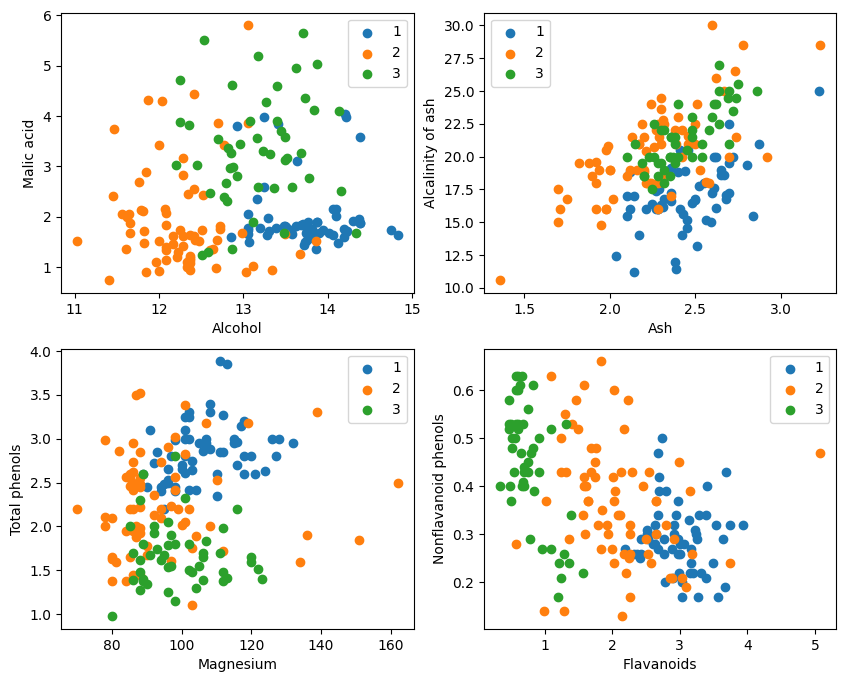

In [7]:
attrs = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
         'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
         'OD280/OD315 of diluted wines', 'Proline']
plt.figure(figsize=(10, 8))
for i in range(0, 4):
    plt.subplot(2, 2, i+1)
    a1, a2 = 2 * i, 2 * i + 1
    plt.scatter(X[:59, a1], X[:59, a2], label='1')
    plt.scatter(X[59:130, a1], X[59:130, a2], label='2')
    plt.scatter(X[130:, a1], X[130:, a2], label='3')
    plt.xlabel(attrs[a1])
    plt.ylabel(attrs[a2])
    plt.legend()
plt.show()

#### 将数据集按128:50划分为训练集（已知类别样本）和验证集（待验证样本）：

In [8]:
train_idx = np.random.choice(178, 128, replace=False)
test_idx = np.array(list(set(range(178)) - set(train_idx)))
X_train, Y_train = X[train_idx], Y[train_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

## 5、模型构建--计算距离
利用MindSpore提供的`tile, square, ReduceSum, sqrt, TopK`等算子，通过矩阵运算的方式同时计算输入样本x和已明确分类的其他样本X_train的距离，并计算出top k近邻

In [9]:
class KnnNet(nn.Cell):
    def __init__(self, k):
        super(KnnNet, self).__init__()
        self.k = k

    def construct(self, x, X_train):
        #平铺输入x以匹配X_train中的样本数
        x_tile = ops.tile(x, (128, 1))
        square_diff = ops.square(x_tile - X_train)
        square_dist = ops.sum(square_diff, 1)
        dist = ops.sqrt(square_dist)
        #-dist表示值越大，样本就越接近
        values, indices = ops.topk(-dist, self.k)
        return indices

def knn(knn_net, x, X_train, Y_train):
    x, X_train = ms.Tensor(x), ms.Tensor(X_train)
    indices = knn_net(x, X_train)
    topk_cls = [0]*len(indices.asnumpy())
    for idx in indices.asnumpy():
        topk_cls[Y_train[idx]] += 1
    cls = np.argmax(topk_cls)
    return cls

## 6、模型预测
在验证集上验证KNN算法的有效性，取$k = 5$，验证精度接近80%，说明KNN算法在该3分类任务上有效，能根据酒的13种属性判断出酒的品种。

In [10]:
acc = 0
knn_net = KnnNet(5)
for x, y in zip(X_test, Y_test):
    pred = knn(knn_net, x, X_train, Y_train)
    acc += (pred == y)
    print('label: %d, prediction: %s' % (y, pred))
print('Validation accuracy is %f' % (acc/len(Y_test)))

label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 2
label: 1, prediction: 1
label: 3, prediction: 2
label: 3, prediction: 3
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 3, prediction: 1
label: 3, prediction: 2
label: 1, prediction: 1
label: 3, prediction: 2
label: 3, prediction: 2
label: 3, prediction: 3
label: 1, prediction: 1
label: 3, prediction: 2
label: 3, prediction: 2
label: 3, prediction: 3
label: 1, prediction: 1
label: 1, prediction: 1
label: 3, prediction: 3
label: 3, prediction: 1
label: 1, prediction: 1
label: 3, prediction: 2
label: 1, prediction: 1
label: 1, prediction: 1
label: 3, prediction: 3
label: 3, prediction: 1
label: 1, prediction: 1
label: 3, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 1
label: 2, prediction: 1
label: 2, prediction: 1
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 3
label: 2, prediction: 3
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, predic

## 实验小结
本实验使用MindSpore实现了KNN算法，用来解决3分类问题。取wine数据集上的3类样本，分为已知类别样本和待验证样本，从验证结果可以看出KNN算法在该任务上有效，能根据酒的13种属性判断出酒的品种。
